# 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

# 2. Import Dataset

Source of the dataset: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data

In [2]:
df_train = pd.read_csv('train.csv')
df_store = pd.read_csv('stores.csv')
df_holiday = pd.read_csv('holidays_events.csv')
df_oil = pd.read_csv('oil.csv')
df_transaction = pd.read_csv('transactions.csv')

# 3. Exploratory Data Analysis

## 3.1. Train Dataset

In [3]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
df_train.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


### Data Information

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [6]:
df_train['date'] = pd.to_datetime(df_train['date'])

### Data Train Description

In [7]:
df_train.describe()

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


In [8]:
df_train.describe(include='O')

,family
count,3000888
unique,33
top,AUTOMOTIVE
freq,90936


In [9]:
family = df_train.groupby('family').sales.sum().sort_values(ascending=False).head().to_frame()
family

,sales
family,
GROCERY I,3.434627e+08
BEVERAGES,2.169545e+08
PRODUCE,1.227047e+08
CLEANING,9.752129e+07
DAIRY,6.448771e+07


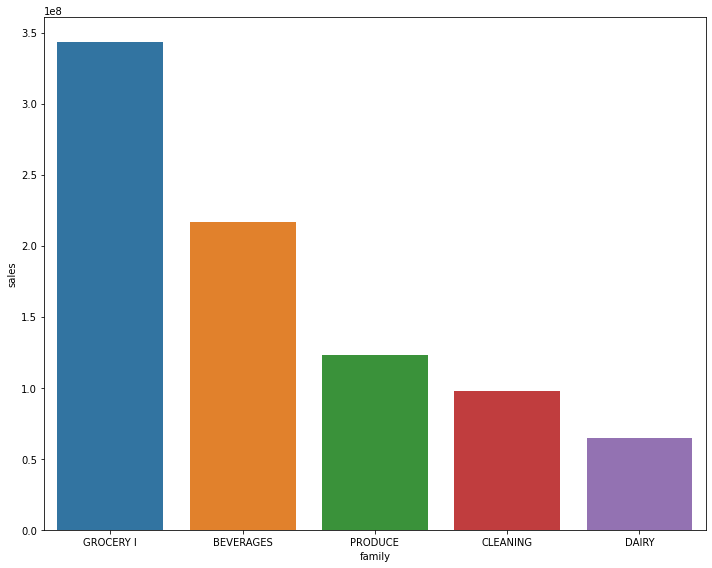

In [10]:
plt.figure(figsize=(10,8))
sns.barplot(data= family, x=family.index, y='sales')
plt.tight_layout()

`Berdasarkan hasil di atas, ternyata penjualan grosiran memiliki total penjualan paling tinggi dibandingkan tipe jualan lainnya. Untuk itu, di sini saya memilih nilai daata dengan tipe penjualan grosir (GROCERY I) untuk dilakukan analisa lebih lanjut dalam melakukan forecasting.`

In [11]:
df_train_grocery = df_train[df_train.family == 'GROCERY I']

In [12]:
df_train_grocery.head()

,id,date,store_nbr,family,sales,onpromotion
12,12,2013-01-01,1,GROCERY I,0.0,0
45,45,2013-01-01,10,GROCERY I,0.0,0
78,78,2013-01-01,11,GROCERY I,0.0,0
111,111,2013-01-01,12,GROCERY I,0.0,0
144,144,2013-01-01,13,GROCERY I,0.0,0


### Rata-rata penjualan toko grosir setiap hari

In [13]:
rata2_toko = df_train_grocery.groupby('store_nbr').sales.mean().sort_values(ascending = False).to_frame()
rata2_toko

,sales
store_nbr,
44,9730.436483
45,9708.878439
47,9212.902904
46,8516.782660
3,7702.178130
48,7619.355173
49,6584.311164
11,6558.757992
9,6147.920998


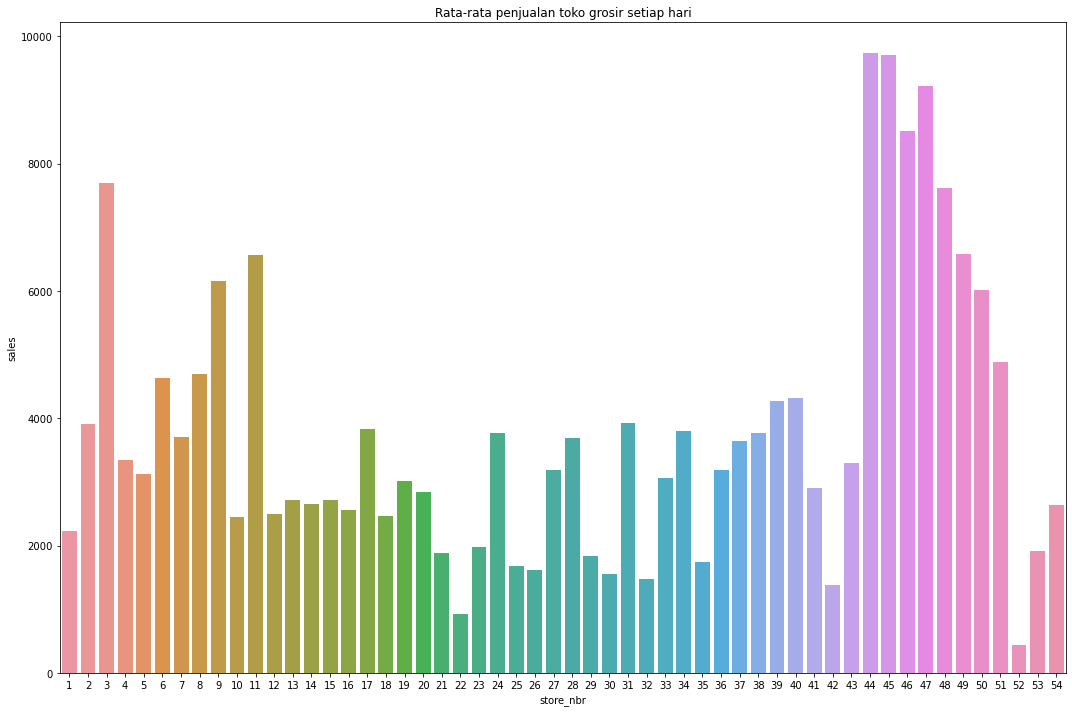

In [14]:
plt.figure(figsize=(15,10))
sns.barplot(data= rata2_toko, x=rata2_toko.index, y='sales')
plt.title('Rata-rata penjualan toko grosir setiap hari')
plt.tight_layout()

`Berdasarkan hasil di atas, ternyata rata-rata penjualan grosir tertinggi ada di toko yang memiliki nomor 44 sebesar 9730.436, diikuti dengan store bernomor 45 sebesar 9708.878, dan toko yang memiliki penjualan grosir yaag paling rendah ada di toko bernomor 52 sebesar 437.181.`

### Total penjualan setiap hari

In [15]:
df_train_grocery

,id,date,store_nbr,family,sales,onpromotion
12,12,2013-01-01,1,GROCERY I,0.000,0
45,45,2013-01-01,10,GROCERY I,0.000,0
78,78,2013-01-01,11,GROCERY I,0.000,0
111,111,2013-01-01,12,GROCERY I,0.000,0
144,144,2013-01-01,13,GROCERY I,0.000,0
...,...,...,...,...,...,...
3000735,3000735,2017-08-15,54,GROCERY I,4235.000,44
3000768,3000768,2017-08-15,6,GROCERY I,4334.000,33
3000801,3000801,2017-08-15,7,GROCERY I,3678.000,34
3000834,3000834,2017-08-15,8,GROCERY I,4035.000,34


In [16]:
df_train_grocery= df_train_grocery.groupby(['date'])[['sales', 'onpromotion']].sum().reset_index()

df_train_grocery.sort_values(by='sales',ascending=False).head()

,date,sales,onpromotion
1200,2016-04-18,583222.480,1569
1547,2017-04-01,474003.906,2743
1199,2016-04-17,456372.940,1468
1203,2016-04-21,438060.072,1808
1201,2016-04-19,432782.685,1529


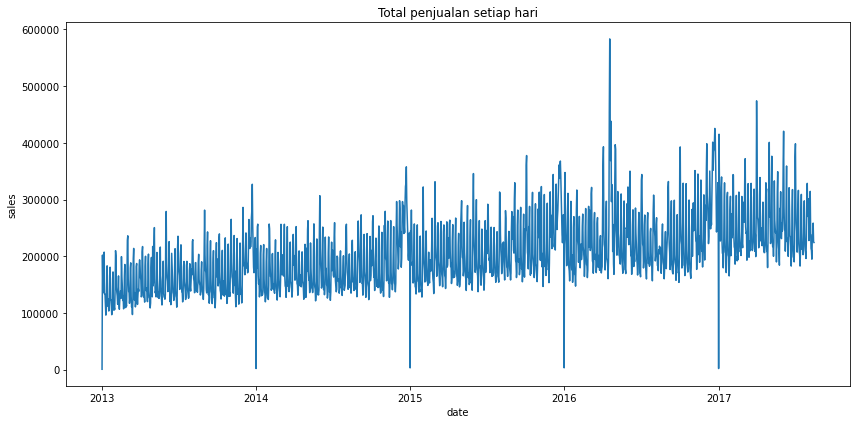

In [17]:
plt.figure(figsize=(12,6))
sns.lineplot(data= df_train_grocery, x='date', y='sales')
plt.title('Total penjualan setiap hari')
plt.tight_layout()

`Total penjualan yang paling besar terjadi pada tanggal 18 april 2016 dengan jumlah promosi sebanyak 583222.480.`

In [18]:
print(df_train_grocery.date.shape[0])
len(pd.date_range(start=min(df_train_grocery['date']),end=max(df_train_grocery['date'])))

1684


1688

`Dapat dilihat, ternyata terdapat perbedaan jumlah baris antara data 'train' dan tanggal aktual. Hal ini mungkin di dalam datasetnya tidak terdapat transaksi ketika hari raya Natal.`

`Karena datasetnya dimulai dari januari 2013 sampai agustus 2017, maka sangat wajar jika terdapat 4 tanggal yang hilang.`

In [19]:
tanggal = pd.date_range(start=min(df_train['date']),end=max(df_train['date']))
tanggal

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', length=1688, freq='D')

In [20]:
tanggal = pd.DataFrame(tanggal, columns=['date'])
tanggal.head()

,date
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05


In [21]:
df_train_grocery = df_train_grocery.merge(tanggal, on='date', how='right')
df_train_grocery

,date,sales,onpromotion
0,2013-01-01,700.000,0.0
1,2013-01-02,202020.000,0.0
2,2013-01-03,144878.000,0.0
3,2013-01-04,135754.000,0.0
4,2013-01-05,188356.000,0.0
...,...,...,...
1683,2017-08-11,238221.922,2349.0
1684,2017-08-12,238627.633,2325.0
1685,2017-08-13,258442.452,2320.0
1686,2017-08-14,225355.694,2335.0


In [22]:
df_train_grocery.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1688 entries, 0 to 1687
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1688 non-null   datetime64[ns]
 1   sales        1684 non-null   float64       
 2   onpromotion  1684 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 52.8 KB


`Terdapat 4 missing value pada kolom sales dan onpromotion`

### Handling Missing Value

In [23]:
df_train_grocery[df_train_grocery.sales.isna()]

,date,sales,onpromotion
358,2013-12-25,NaN,NaN
723,2014-12-25,NaN,NaN
1088,2015-12-25,NaN,NaN
1454,2016-12-25,NaN,NaN


`Ternyata benar, kolom sales dan onpromotion pada dataset ini berisi missing value setiap hari raya Natal. Hal ini menandakan kalau pada tanggal tersebut tidak terdapat transaksi apa-apa di dalamnya.`

### Impute Missing Value

In [24]:
df_train_grocery.fillna(0, inplace=True)

In [25]:
df_train_grocery.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1688 entries, 0 to 1687
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1688 non-null   datetime64[ns]
 1   sales        1688 non-null   float64       
 2   onpromotion  1688 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 52.8 KB


`Karena nilai missing value yang ada itu terjadi pada hari raya Natal yang mengindikasikan tidak terdapat aktivitas transaksi apa-apa, maka di sini saya mengisi nilai pada kolom 'sales' dan 'onpromotion' dengan angka 0.`

### Total penjualan tertinggi setiap tahun

In [26]:
date = df_train_grocery.date.dt

In [27]:
def year (sales_max):
    if sales_max == 2013 :
        sales_max = df_train_grocery[(date.year == sales_max)].sales.max() 
        return(f'Total pejualan tertinggi pada tahun 2013 sebesar {sales_max}')
        
    elif sales_max == 2014:
        sales_max = df_train_grocery[(date.year == sales_max)].sales.max() 
        return(f'Total pejualan tertinggi pada tahun 2014 sebesar {sales_max}')
        
    elif sales_max == 2015:
        sales_max = df_train_grocery[(date.year == sales_max)].sales.max() 
        return(f'Total pejualan tertinggi pada tahun 2015 sebesar {sales_max}')

    elif sales_max == 2016:
        sales_max = df_train_grocery[(date.year == sales_max)].sales.max() 
        return(f'Total pejualan tertinggi pada tahun 2016 sebesar {sales_max}')
        
    else:
        sales_max = df_train_grocery[(date.year == sales_max)].sales.max() 
        return(f'Total pejualan tertinggi pada tahun 2017 sebesar {sales_max}')

In [28]:
print(year(2013))
print(year(2014))
print(year(2015))
print(year(2016))
print(year(2017))

Total pejualan tertinggi pada tahun 2013 sebesar 326975.0
Total pejualan tertinggi pada tahun 2014 sebesar 357665.078
Total pejualan tertinggi pada tahun 2015 sebesar 377564.83400000003
Total pejualan tertinggi pada tahun 2016 sebesar 583222.48
Total pejualan tertinggi pada tahun 2017 sebesar 474003.906


## 3.2 Holiday Dataset

In [29]:
df_holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


### Data Information

In [30]:
df_holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


### Data Description

In [31]:
df_holiday.describe()

,date,type,locale,locale_name,description,transferred
count,350,350,350,350,350,350
unique,312,6,3,24,103,2
top,2014-06-25,Holiday,National,Ecuador,Carnaval,False
freq,4,221,174,174,10,338


In [32]:
df_holiday.describe(include='O')

,date,type,locale,locale_name,description
count,350,350,350,350,350
unique,312,6,3,24,103
top,2014-06-25,Holiday,National,Ecuador,Carnaval
freq,4,221,174,174,10


In [33]:
df_holiday['date'] = pd.to_datetime(df_holiday['date'])

In [34]:
df_train_grocery.merge(df_holiday, on='date', how='left')

,date,sales,onpromotion,type,locale,locale_name,description,transferred
0,2013-01-01,700.000,0.0,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-02,202020.000,0.0,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,144878.000,0.0,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,135754.000,0.0,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,188356.000,0.0,Work Day,National,Ecuador,Recupero puente Navidad,False
...,...,...,...,...,...,...,...,...
1713,2017-08-11,238221.922,2349.0,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False
1714,2017-08-12,238627.633,2325.0,NaN,NaN,NaN,NaN,NaN
1715,2017-08-13,258442.452,2320.0,NaN,NaN,NaN,NaN,NaN
1716,2017-08-14,225355.694,2335.0,NaN,NaN,NaN,NaN,NaN


In [35]:
df_train_grocery['holiday'] = df_train_grocery.date.isin(df_holiday.date)
df_train_grocery

,date,sales,onpromotion,holiday
0,2013-01-01,700.000,0.0,True
1,2013-01-02,202020.000,0.0,False
2,2013-01-03,144878.000,0.0,False
3,2013-01-04,135754.000,0.0,False
4,2013-01-05,188356.000,0.0,True
...,...,...,...,...
1683,2017-08-11,238221.922,2349.0,True
1684,2017-08-12,238627.633,2325.0,False
1685,2017-08-13,258442.452,2320.0,False
1686,2017-08-14,225355.694,2335.0,False


In [36]:
df_train_grocery.holiday.value_counts(normalize=True)

False    0.848341
True     0.151659
Name: holiday, dtype: float64

### Perbandingan penjualan yang terjadi ketika libur

In [37]:
holiday = df_train_grocery.groupby('holiday')['sales'].sum()

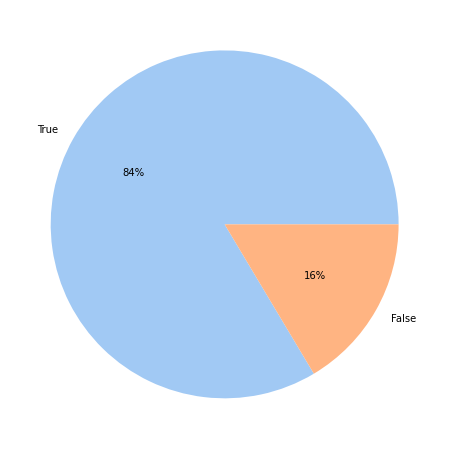

In [38]:
colors = sns.color_palette('pastel')
plt.figure(figsize=(10,8))
plt.pie(holiday, colors=colors,autopct='%.0f%%', labels=df_train_grocery.holiday.unique())
plt.show()

`Berdasarkan hasil di atas, ternyata persentase penjualan lebih banyak terjadi ketika tidak libur.`

## 3.3 Transactions Dataset

In [39]:
df_transaction

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


### Data Information

In [40]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [41]:
df_transaction['date'] = pd.to_datetime(df_transaction.date)

### Data Description

In [42]:
df_transaction.describe()

,store_nbr,transactions
count,83488.000000,83488.000000
mean,26.939237,1694.602158
std,15.608204,963.286644
min,1.000000,5.000000
25%,13.000000,1046.000000
50%,27.000000,1393.000000
75%,40.000000,2079.000000
max,54.000000,8359.000000


### Total transaksi yang terjadi setiap toko

In [43]:
store_transaction = df_transaction.groupby('store_nbr').transactions.sum().to_frame()

Text(0.5, 1.0, 'Total transaksi yang terjadi setiap toko')

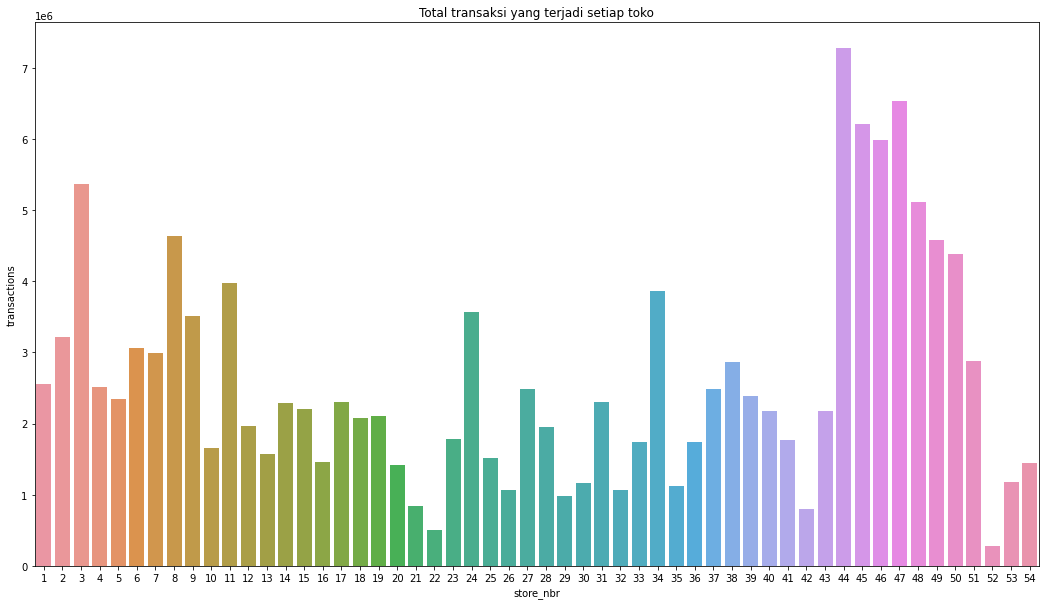

In [44]:
plt.figure(figsize=(18,10))
sns.barplot(x=store_transaction.index, y='transactions', data=store_transaction)
plt.title('Total transaksi yang terjadi setiap toko')

`Berdasarkan hasil visualisasi di atas, ternyata, store dengan nomor 44 memiliki jumlah transaksi terbanyak, yakni sebesar 7273093, jumlah sedangkan transaksi yang paling sedikit ada pada store dengan nomor 52, yakni sebesar 275393.`

### Merge dataframe

In [45]:
df_transaction = df_transaction.groupby('date')['transactions'].sum().reset_index()
df_train_grocery= df_train_grocery.merge(df_transaction, on='date', how='left')
df_train_grocery.head()

,date,sales,onpromotion,holiday,transactions
0,2013-01-01,700.0,0.0,True,770.0
1,2013-01-02,202020.0,0.0,False,93215.0
2,2013-01-03,144878.0,0.0,False,78504.0
3,2013-01-04,135754.0,0.0,False,78494.0
4,2013-01-05,188356.0,0.0,True,93573.0


In [46]:
df_train_grocery.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1688 entries, 0 to 1687
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1688 non-null   datetime64[ns]
 1   sales         1688 non-null   float64       
 2   onpromotion   1688 non-null   float64       
 3   holiday       1688 non-null   bool          
 4   transactions  1682 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(3)
memory usage: 67.6 KB


In [47]:
date = df_train_grocery.date.dt

In [48]:
df_train_grocery[df_train_grocery.transactions.isnull()]

,date,sales,onpromotion,holiday,transactions
358,2013-12-25,0.000,0.0,True,NaN
723,2014-12-25,0.000,0.0,True,NaN
1088,2015-12-25,0.000,0.0,True,NaN
1095,2016-01-01,3247.000,4.0,True,NaN
1097,2016-01-03,347681.912,589.0,False,NaN
1454,2016-12-25,0.000,0.0,True,NaN


```
Terdapat beberapa nilai missing value pada kolom 'transactions' terhadap tanggal tertentu. Untuk itu, saya akan mengimpute nilai missing value tersebut dengan beberapa metode sesuai dengan kondisi:
2013-12-25 ==> Hari raya Natal ==> impute dengan nilai 0
2014-12-25 ==> Hari raya Natal ==> impute dengan nilai 0
2015-12-25 ==> Hari raya Natal ==> impute dengan nilai 0
2016-12-25 ==> Hari raya Natal ==> impute dengan nilai 0
2016-01-01 ==> Libur awal tahun ==> impute dengan nilai 0
```

In [49]:
df_train_grocery[date.day == 25] = df_train_grocery[date.day == 25].fillna(0)
df_train_grocery[date.day == 1] = df_train_grocery[date.day == 1].fillna(0)

In [50]:
df_train_grocery[df_train_grocery.transactions.isnull()]

,date,sales,onpromotion,holiday,transactions
1097,2016-01-03,347681.912,589.0,False,NaN


`Ternyata, masih terdapat missing value pada kolom 'transactions' pada tanggal '2016-01-03'. Untuk mengisi missing value tersebut, maka saya akan menganalisis datanya terlebih dahulu.`

In [51]:
df_train_grocery[(date.year==2016) & (date.month==1)]

,date,sales,onpromotion,holiday,transactions
1095,2016-01-01,3247.000,4.0,True,0.0
1096,2016-01-02,309417.194,474.0,False,69628.0
1097,2016-01-03,347681.912,589.0,False,NaN
1098,2016-01-04,272978.806,512.0,False,17829.0
1099,2016-01-05,234212.722,491.0,False,89018.0
1100,2016-01-06,220632.777,548.0,False,88846.0
1101,2016-01-07,183343.476,595.0,False,80412.0
1102,2016-01-08,194604.367,438.0,False,83344.0
1103,2016-01-09,277982.051,489.0,False,100975.0
1104,2016-01-10,310926.818,456.0,False,97323.0


In [52]:
mean_value = df_train_grocery.transactions[(date.year==2016) & (date.month==1)].mean()
mean_value

79040.16666666667

In [53]:
df_train_grocery.transactions.fillna(mean_value, inplace=True)

`Jika dilihat dari aktifitas pada bulan januari 2016, saat tanggal 2 januari 2016 toko memiliki total promosi 474 dengan total transaksi sebesar 69628. Saya rasa masuk akal jika pada tanggal 3 januari 2016 dengan total promosi 589 nilai transaksinya diisi dengan rata-rata transaksi yang terjadi pada tahun 2016, yakni sebesar 79040.16`

In [54]:
df_train_grocery.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1688 entries, 0 to 1687
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1688 non-null   datetime64[ns]
 1   sales         1688 non-null   float64       
 2   onpromotion   1688 non-null   float64       
 3   holiday       1688 non-null   bool          
 4   transactions  1688 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(3)
memory usage: 67.6 KB


`Missing Value sudah diisi dengan baik.`

### Total transaksi toko grosir perminggu

In [55]:
week_transaction = df_train_grocery.groupby(date.isocalendar().week)['transactions'].sum().to_frame()

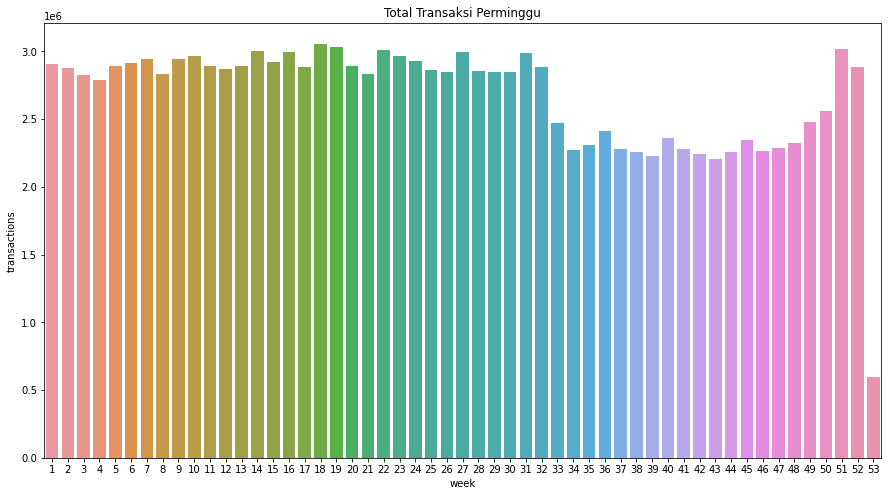

In [56]:
plt.figure(figsize=(15,8))
sns.barplot(x=week_transaction.index, y='transactions', data=week_transaction)
plt.title('Total Transaksi Perminggu');

`Seperti yang bisa kita lihat, aktifitas yang terjadi pada toko groosir di minggu ke-53 merupakan minggu yang memiliki total transaksi paling rendah.`

### Total transaksi toko grosir perbulan

In [57]:
month_transaction = df_train_grocery.groupby(date.month)['transactions'].sum().to_frame()

Text(0.5, 0, 'Month')

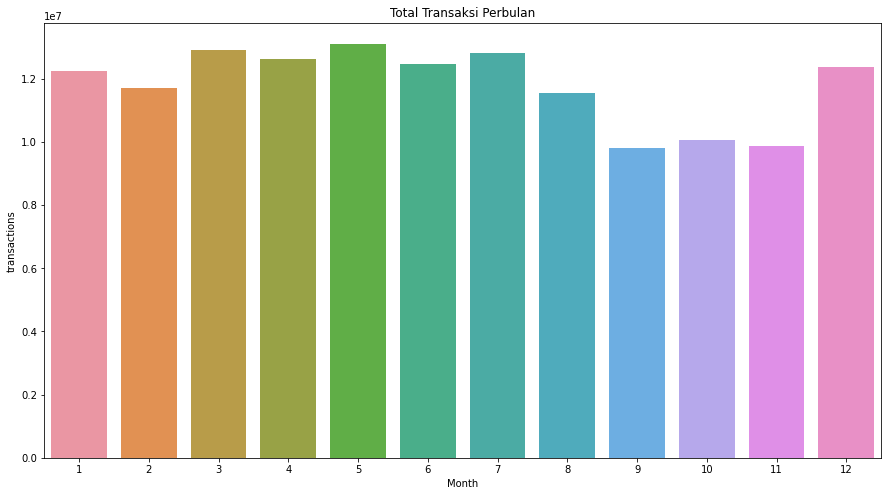

In [58]:
plt.figure(figsize=(15,8))
sns.barplot(x=month_transaction.index, y='transactions', data=month_transaction)
plt.title('Total Transaksi Perbulan')
plt.xlabel('Month')

`Bisa dilihat dari hasil visualisasi di atas, total transaksi pada toko grosir cukup fluktuasi yang mana sempat terjadi penurunan yang drastis pada bulan september, namun meningkat pesat saat bulan desember. Hal ini mungkin customer membeli barang untuk menyambut akhir tahun.`

### Total transaksi toko pertahun

In [59]:
year_transaction = df_train_grocery.groupby(date.year)['transactions'].sum().to_frame()

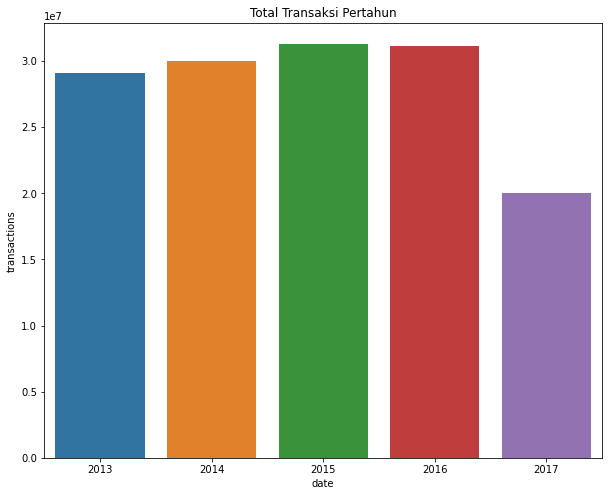

In [60]:
plt.figure(figsize=(10,8))
sns.barplot(x=year_transaction.index, y='transactions', data=year_transaction)
plt.title('Total Transaksi Pertahun');

`Berdasarkan dari hasil visualisasi di atas, total transaksi cenderung meningkat untuk setiap tahunnya, tapi sempat terjadi penurunan di tahun 2017.`

## Correlation Matrix

In [61]:
from jcopml.plot import plot_correlation_matrix, plot_association_matrix

In [62]:
plot_correlation_matrix(df_train_grocery,target_col='sales', numeric_col= ['onpromotion', 'transactions'])

interactive(children=(ToggleButtons(description='method', options=('spearman', 'kendall', 'pearson', 'pearson_…

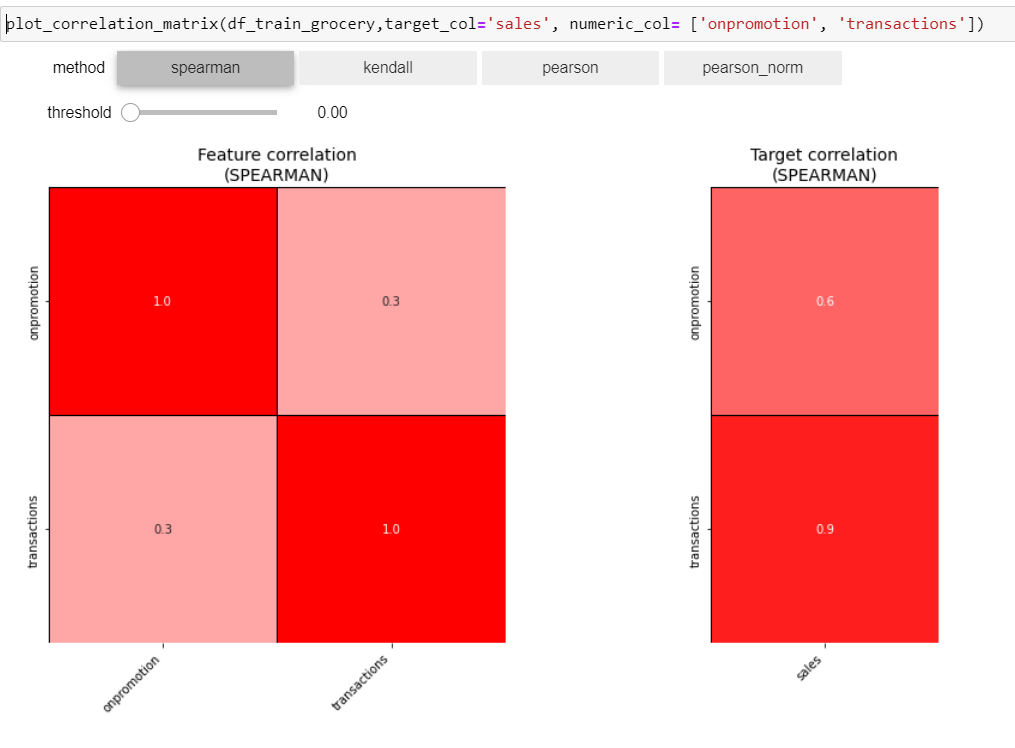

`Karena github tidak bisa menampilkan visualisasi ini, maka saya sudah crop gambarnya untuk menampilkan hasilnya.`

Dapat dilihat, ternyata jumlah transaksi dan jumlah promosi sangat berpengaruh pada harga jual suatu barang.

# 5. Dataset Splitting

In [63]:
df_train_grocery.set_index('date', inplace=True)

In [64]:
df_train_grocery['holiday'] = df_train_grocery.holiday.replace({True: 1, False: 0})

In [65]:
X = df_train_grocery.drop(columns="sales")
y = df_train_grocery.sales

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1350, 3), (338, 3), (1350,), (338,))

# 6. Training Model

In [66]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from jcopml.plot import plot_residual
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [67]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["onpromotion", 'transactions']),
    ('categoric', cat_pipe(encoder='onehot'), ["holiday"]),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])
 
    
model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, scoring='r2', n_iter=200, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 200 candidates, totalling 600 fits
{'algo__colsample_bytree': 0.6231143992803511, 'algo__gamma': 4, 'algo__learning_rate': 0.04378086968092174, 'algo__max_depth': 3, 'algo__n_estimators': 132, 'algo__reg_alpha': 0.029986234021915126, 'algo__reg_lambda': 0.06562538871860242, 'algo__subsample': 0.5743015589690766}
0.8664570796840303 0.8178254557597442 0.8491187740780965


## 6.1. Polynomial Feature

In [68]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ["onpromotion", 'transactions']),
    ('categoric', cat_pipe(encoder='onehot'), ["holiday"])
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])
 
    
model = RandomizedSearchCV(pipeline, rsp.xgb_poly_params, cv=3, scoring='r2', n_iter=200, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 200 candidates, totalling 600 fits
{'algo__colsample_bytree': 0.8136604851450685, 'algo__gamma': 7, 'algo__learning_rate': 0.03578125709488761, 'algo__max_depth': 3, 'algo__n_estimators': 157, 'algo__reg_alpha': 4.46121734930277, 'algo__reg_lambda': 0.006960633318526379, 'algo__subsample': 0.6114832917817414, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': True}
0.8803041246002092 0.8217262647044029 0.8470519447610361


`Ternyata dengan menambahkan poly ke dalam modelnya tidak dapat meningkatkan score model. Untuk itu, pada tahap selanjutnya saya tidak akan menggunakan polynomial feature ke dalam model karena runningnya akan lebih lama sehigga tidak efisien.`

## 6.2. Hyperparameter Tuning

In [69]:
from jcopml.tuning.space import Integer, Real

In [70]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["onpromotion", 'transactions']),
    ('categoric', cat_pipe(encoder='onehot'), ["holiday"])
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])


parameter ={'algo__max_depth': Integer(low=1, high=10),
             'algo__learning_rate': Real(low=-3, high=0, prior='log-uniform'),
             'algo__n_estimators': Integer(low=100, high=200),
             'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
             'algo__gamma': Integer(low=1, high=10),
             'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
             'algo__reg_alpha': Real(low=-1, high=1, prior='log-uniform'),
             'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')}


model = RandomizedSearchCV(pipeline, parameter, cv=3, scoring='r2', n_iter=200, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 200 candidates, totalling 600 fits
{'algo__colsample_bytree': 0.9185720598530367, 'algo__gamma': 5, 'algo__learning_rate': 0.08233373987853591, 'algo__max_depth': 6, 'algo__n_estimators': 118, 'algo__reg_alpha': 0.35353336315527073, 'algo__reg_lambda': 8.628009047476782, 'algo__subsample': 0.5046670031575216}
0.9025050562296753 0.8168689733056657 0.8508683458029243


```
Ternyata model terbaik yang saya dapatkan sebesar 85%

Dengan parameter:
'algo__max_depth': Integer(low=1, high=10), 
'algo__learning_rate': Real(low=-3, high=0, prior='log-uniform'), 
'algo__n_estimators': Integer(low=100, high=200), 
'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'), 
'algo__gamma': Integer(low=1, high=10), 
'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'), 
'algo__reg_alpha': Real(low=-1, high=1, prior='log-uniform'), 
'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')} 
```

# 7. Evaluation

In [71]:
df_analysis1 = X_test.copy()
df_analysis1['pred']  = model.predict(X_test)
df_analysis1['actual'] = y_test
df_analysis1['error'] = np.abs(df_analysis1.pred - df_analysis1.actual)
df_analysis1.sort_values('error').head(10)

,onpromotion,holiday,transactions,pred,actual,error
date,,,,,,
2013-12-17,0.0,0,94103.0,213632.390625,213594.000,38.390625
2015-02-25,201.0,0,75253.0,153548.171875,153616.620,68.448125
2014-06-17,161.0,0,74593.0,150203.171875,150291.872,88.700125
2016-09-14,2426.0,0,73096.0,170901.656250,170787.774,113.882250
2015-11-10,570.0,1,77488.0,181146.062500,180978.383,167.679500
2015-11-19,1130.0,0,74410.0,166337.484375,166160.784,176.700375
2014-11-06,242.0,1,75527.0,156941.359375,156729.929,211.430375
2017-06-03,2773.0,0,106965.0,366592.656250,366851.135,258.478750
2014-06-12,106.0,1,70928.0,131852.484375,132170.707,318.222625


C:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


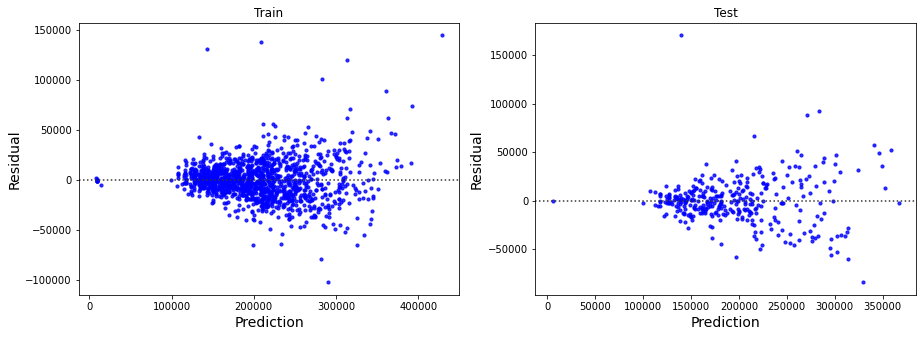

In [72]:
plot_residual(X_train, y_train, X_test, y_test, model)

`Dapat dilihat, visualisasi sebaran data dari hasil prediksi sudah cukup baik yang mana datanya cukup tersebar merata. Hal ini menandakan bahwa model Machine Learning yang dibuat sudah cukup baik.`

# 8. Summary Result

In [73]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print('R2 Train :', r2_score(y_train, y_pred_train))
print('R2 Test :', r2_score(y_test, y_pred_test))
print('MAE Train :', mean_absolute_error(y_train, y_pred_train))
print('MAE Test :', mean_absolute_error(y_test, y_pred_test))
print('MSE Train :', mean_squared_error(y_train, y_pred_train))
print('MSE Test :', mean_squared_error(y_test, y_pred_test))
print('RMSE Train :', mean_squared_error(y_train, y_pred_train, squared=False))
print('RMSE Test :', mean_squared_error(y_test, y_pred_test, squared=False))

R2 Train : 0.9025050562296753
R2 Test : 0.8508683458029243
MAE Train : 13606.183792951388
MAE Test : 16308.476523379715
MSE Train : 381744910.20053023
MSE Test : 573000880.961102
RMSE Train : 19538.29343111957
RMSE Test : 23937.43680850358
